# Project Data Analysis - Investigation of European Soccer Database
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
The following questions are investigated in this notebook:  
1. Does ball possession correlate with the goal difference (goals scored - goals conceded) and the shot difference (shots taken - shots allowed) in a soccer match?
2. Who are the players with the best goal conversion rate (goals scored / total shots taken) over the seasons?
3. Is there a pattern in the distribution of the numbers of goals scored in soccer matches?

The analysis is based on the comprehensive European soccer database of the user Hugo Mathien on Kaggle:
https://www.kaggle.com/hugomathien/soccer


In [103]:
# besides pandas, numpy and matplotlib we need the library sqlalchemy for importing
# the database from sqlite as well as xml.etree.ElementTree for dealing with xml data
# hidden in several columns of the table 'Match'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sqla
import xml.etree.ElementTree as ET
import seaborn as sns
from scipy.stats import poisson
%matplotlib inline
plt.style.use('fivethirtyeight')

> **Comment:** Besides Pandas, Numpy and Matplotlib we need the library SQLAlchemy for importing
the database from sqlite as well as xml.etree.ElementTree for dealing with XML data
hidden in several columns of the table 'Match'

<a id='wrangling'></a>
## Data Wrangling

**Load data**:   
In order to address the 3 questions posed in the introduction above we will try to gain data frames with certain properties and columns  
in the course of the data wrangling process:
1. Data frame `df_matches` with columns to calculate the correlation of ball possession and goal difference / shot difference.
2. Data frame `df_players` with additional columns 'total shots taken' and 'goals scored' to calculate the corresponding goal conversion rate.
3. Data frame `df_matches` should already come with all necessary information.

### General Properties
In a first approach we extract already filtered raw data from the sqlite database.  
The query for match data ignores all records not having valid information in the  
columns 'possession', 'goal', 'shoton', 'shotoff' which are relevant for the study at hand.

In [10]:
# build sql query to extract match data - ignore data without valid possession, shot and goal data
query_match = """
select match.id as match_id, date, league.name, season, possession, home_team.Team_long_name, away_team.Team_long_name, home_team_api_id,away_team_api_id, home_team_goal, away_team_goal, shoton, shotoff, goal
from Match inner join league on match.league_id = league.id
inner join team as home_team on home_team.team_api_id = match.home_team_api_id
inner join team as away_team on away_team.team_api_id = match.away_team_api_id
where possession is  not null and possession <> '<possession />' and goal is not null and shoton is not null and shotoff is not null;
 """
query_player = """
select player_api_id, player_name from player;
 """
db = sqla.create_engine('sqlite:///data/database.sqlite')
df_match_raw = pd.read_sql(query_match, db)
df_player_raw = pd.read_sql(query_player,db)
# dump 5 sample records
df_match_raw.sample(5)

,match_id,date,name,season,possession,team_long_name,team_long_name,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,shoton,shotoff,goal
1153,2887,2011-10-29 00:00:00,England Premier League,2011/2012,<possession><value><comment>37</comment><event...,West Bromwich Albion,Liverpool,8659,8650,0,2,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<goal><value><comment>p</comment><stats><penal...
4040,8504,2011-01-14 00:00:00,Germany 1. Bundesliga,2010/2011,<possession><value><comment>52</comment><event...,Bayer 04 Leverkusen,Borussia Dortmund,8178,9789,1,3,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><event_incident_typefk>591</ev...,<goal><value><comment>n</comment><stats><goals...
5144,10822,2010-02-28 00:00:00,Italy Serie A,2009/2010,<possession><value><comment>45</comment><event...,Udinese,Inter,8600,8636,2,3,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<goal><value><comment>n</comment><stats><goals...
6381,13203,2016-05-08 00:00:00,Italy Serie A,2015/2016,<possession><value><comment>68</comment><stats...,Atalanta,Udinese,8524,8600,1,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<goal><value><comment>n</comment><stats><goals...
6734,15685,2015-09-13 00:00:00,Netherlands Eredivisie,2015/2016,<possession><value><comment>33</comment><stats...,FC Utrecht,Vitesse,9908,8277,2,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<goal><value><comment>n</comment><stats><goals...


In [11]:
df_match_raw.dtypes

match_id             int64
date                object
name                object
season              object
possession          object
team_long_name      object
team_long_name      object
home_team_api_id     int64
away_team_api_id     int64
home_team_goal       int64
away_team_goal       int64
shoton              object
shotoff             object
goal                object
dtype: object

> **Comment:** In the sample records of `df_match_raw` we can see that data on shots, goals and possession are in xml format which we dig into later on in the
data cleaning section. The date is in string format and will be casted to pandas datetime type later.

In [12]:
df_player_raw.sample(5)

,player_api_id,player_name
3441,102725,Fouad Idabdelhay
5245,150739,Jordi Alba
9620,33930,Seid Khiter
8416,362665,Paulinho
10715,500939,Wallyson Mallmann


In [13]:
df_player_raw.dtypes

player_api_id     int64
player_name      object
dtype: object

> **Comment:** Not much to do about `df_player_raw` at the moment.

### Data Cleaning
First defining some helper functions, for further details see also the comments in the definitions of the code.

- `def flatten(list_of_list)` - little helper function to deal with lists of lists which we will face occasionally
- `def build_shotlists_from_xml(xmlstring, matchid)` - function to extract the xml data from the column 'possession'.
- `def build_possession_row_from_xml(xmlstring, matchid)`- function to extract the xml data from the columns 'shoton', 'shotoff' and 'goals'.




In [14]:
# Helper function flatten, flattening of lists. occassionally we have to deal with lists of lists
#which have to be flattened to be used in data frames.
def flatten(list_of_list):
    flattened_list = [y for x in list_of_list for y in x]
    return flattened_list

# Helper function to extract xml data from the column possession of data frame df_match
def build_possession_row_from_xml(xmlstring, matchid):
    root = ET.fromstring(xmlstring)
    # we are interested in the last entry only, usually the possession values after 90 minutes
    tags = root.findall("value[last()]")

    rows = []
    #there should be only one tag found, but leaving loop for possible later changes
    for node in tags:
        elapsed = node.findtext("elapsed") if node is not None else None
        homepos = node.findtext("homepos") if node is not None else None
        
        awaypos = node.findtext("awaypos") if node is not None else None
        rows.append({"match_id": matchid, "elapsed": elapsed, "homepos": homepos, 
                     "awaypos": awaypos})
    if rows.count == 0:
        return  None
    else:
        #return value is a list of dictionaries
        return rows

# Helper function to extract xml data from the columns shoton,shotoff and goals of df_match
def build_shotlists_from_xml(xmlstring, matchid):
    root = ET.fromstring(xmlstring)
    rows = []
    for node in root: 
        elapsed = node.findtext("elapsed") if node is not None else None
        team = node.findtext("team") if node is not None else None
        type_s = node.findtext("type") if node is not None else None
        player = node.findtext("player1") if node is not None else None
        subtype = node.findtext('subtype') if node is not None else None
        goalno = node.findtext('stats/goal') if node is not None else None
        shotonno = node.findtext('stats/shoton') if node is not None else None
        shotoffno = node.findtext('stats/shotoff') if node is not None else None
        
        rows.append({"match_id": matchid, "elapsed": elapsed, "team": team, "player": player, "subtype" : subtype,
                     "type": type_s, 'goal_no' : goalno, 'shoton_no' : shotonno, 'shotoff_no' : shotoffno, 'shotcnt': 1})
    if rows.count == 0:
        return  None
    else:
        return rows

> **create additional data frames**  
Creating some extra data frames from xml content of some columns of the `df_match` data frame with the code of next cells.  
These data frames are needed later for further analysis.

#### Data wrangling for  `df_match_raw`
Tasks:
- cast 'date' to pandas datetime
- create new data frame `df_pos` from xml possession data
- create new data frame `df_shots`from xml shotson, shotsoff and goal data.

In [15]:
# converting date to date time
df_match_raw['date'] = pd.to_datetime(df_match_raw.date)
# dump types to check result:
df_match_raw.dtypes

match_id                     int64
date                datetime64[ns]
name                        object
season                      object
possession                  object
team_long_name              object
team_long_name              object
home_team_api_id             int64
away_team_api_id             int64
home_team_goal               int64
away_team_goal               int64
shoton                      object
shotoff                     object
goal                        object
dtype: object

In [16]:
# parse xml data of column possession with helper funcion
# use apply to extract the xml data and store result in rows_pos
rows_pos = df_match_raw.apply(lambda x : build_possession_row_from_xml(x['possession'], x['match_id']), axis=1)
# flatten the results and create new data frame df_pos
df_pos = pd.DataFrame(flatten(rows_pos.values.tolist()))
# dump samples
df_pos.sample(3)

,match_id,elapsed,homepos,awaypos
7849,23988,90,55,45
5365,11214,90,57,43
3883,8160,68,52,48


do some checks on the new data frame `df_pos`:

In [17]:
df_pos.dtypes

match_id     int64
elapsed     object
homepos     object
awaypos     object
dtype: object

In [18]:
df_pos.isna().sum()

match_id    0
elapsed     0
homepos     2
awaypos     2
dtype: int64


> **Comment:** 3 columns of new data frame `df_pos` are all strings because of the previous xml parsing.  
So, casting columns to ints. *homepos, awaypos* both have NaNs in certain rows. We have to drop affected rows first.



In [19]:
# get rid of rows with NaNs in homepos or awaypos
df_pos.dropna(subset=['homepos','awaypos'], inplace=True)
# set all columns to int64 and check with dtype
df_pos = df_pos.astype('int64')
# check result:
df_pos.dtypes

match_id    int64
elapsed     int64
homepos     int64
awaypos     int64
dtype: object

#### Create data frame `df_shots` from shotson, shotsoff and goal data

This is a similar process to the build-up of `df_pos` above. We extract the xml
data from 3 columns this time. Since the structure of the relevant columns 'goal',
'shoton' and 'shotoff' are sufficiently similar we can treat them in the same way.
In the end we will have a `df_shots` data frame as a union of the data from all
three columns.

In [20]:
# extract shoton data from xml 
rows_on = df_match_raw.apply(lambda x : build_shotlists_from_xml(x['shoton'], x['match_id']), axis=1)
df_shoton = pd.DataFrame(flatten(rows_on.values.tolist()))
#extract shotoff data from xml
rows_off = df_match_raw.apply(lambda x : build_shotlists_from_xml(x['shotoff'], x['match_id']), axis=1)
df_shotoff = pd.DataFrame(flatten(rows_off.values.tolist()))
# extract goal data from xml:
rows_goals = df_match_raw.apply(lambda x : build_shotlists_from_xml(x['goal'], x['match_id']), axis=1)
df_goal = pd.DataFrame(flatten(rows_goals.values.tolist()))
# now build a union of the 3 temporary data frames df_shotoff, df_shoton, df_goal
df_shots = pd.concat([df_shotoff, df_shoton, df_goal])
df_shots.head()

,match_id,elapsed,team,player,subtype,type,goal_no,shoton_no,shotoff_no,shotcnt
0,1729,4,10260,30373,distance,shotoff,None,None,1,1
1,1729,5,10261,37799,distance,shotoff,None,None,1,1
2,1729,22,10261,24228,deflected,shotoff,None,None,1,1
3,1729,31,10261,38807,distance,shotoff,None,None,1,1
4,1729,34,10260,24154,header,shotoff,None,None,1,1


In [21]:
df_shots.dtypes

match_id       int64
elapsed       object
team          object
player        object
subtype       object
type          object
goal_no       object
shoton_no     object
shotoff_no    object
shotcnt        int64
dtype: object

In [22]:
# most columns are string due to the xml parsing process,
# but we need numeric values in several columns:
df_shots['player'] = pd.to_numeric(df_shots['player'], errors='coerce')
df_shots['team'] = pd.to_numeric(df_shots['team'],  errors='coerce')
df_shots.dtypes

match_id        int64
elapsed        object
team          float64
player        float64
subtype        object
type           object
goal_no        object
shoton_no      object
shotoff_no     object
shotcnt         int64
dtype: object

#### Next step: Create `df_matches`
Now we are going to build the table `df_matches` in order to address the raised questions 1 and 3. First we are going to merge `df_pos` with df `df_match_raw` to add possession data to matches.

In [23]:
# merging df_pos with df_match_raw
df_matches = pd.merge(df_match_raw, df_pos, on='match_id')
# get rid of columns possession, shoton, shotoff and goal, we don't need them anymore because we already extracted their xml data
df_matches.drop(['possession', 'shoton', 'shotoff', 'goal'], axis=1, inplace=True)
df_matches.sample(3)

,match_id,date,name,season,team_long_name,team_long_name,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,elapsed,homepos,awaypos
8049,24190,2015-10-31,Spain LIGA BBVA,2015/2016,Villarreal CF,Sevilla FC,10205,8302,2,1,90,50,50
7016,21998,2010-01-24,Spain LIGA BBVA,2009/2010,Getafe CF,Atlético Madrid,8305,9906,1,0,90,55,45
5629,11638,2012-04-25,Italy Serie A,2011/2012,Roma,Fiorentina,8686,8535,1,2,90,65,35


> now adding a column with the goal difference

In [24]:
df_matches['goaldiff'] = df_matches['home_team_goal'] - df_matches['away_team_goal']

> now we want to add two columns to `df_matches` with shots taken by home and away team.  
To this end
we will create a groupby from the shots table:

In [25]:
shots_group = df_shots.groupby(['match_id', 'team'],group_keys=False)['shotcnt'].sum().reset_index()
shots_group.head(5)

,match_id,team,shotcnt
0,1729,10260.0,22
1,1729,10261.0,11
2,1730,8659.0,5
3,1730,9825.0,26
4,1731,8472.0,7


> let's now merge the `shots_group` to `df_matches` to obtain the desired two new columns:

In [26]:
df_matches = df_matches.merge(shots_group, left_on=['match_id','home_team_api_id'], right_on=['match_id', 'team'])
df_matches = df_matches.merge(shots_group, left_on=['match_id','away_team_api_id'], right_on=['match_id', 'team'])
df_matches.head(3)

,match_id,date,name,season,team_long_name,team_long_name,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,elapsed,homepos,awaypos,goaldiff,team_x,shotcnt_x,team_y,shotcnt_y
0,1729,2008-08-17,England Premier League,2008/2009,Manchester United,Newcastle United,10260,10261,1,1,90,55,45,0,10260.0,22,10261.0,11
1,1730,2008-08-16,England Premier League,2008/2009,Arsenal,West Bromwich Albion,9825,8659,1,0,90,66,34,1,9825.0,26,8659.0,5
2,1731,2008-08-16,England Premier League,2008/2009,Sunderland,Liverpool,8472,8650,0,1,90,46,54,-1,8472.0,7,8650.0,17


> a few cleaning tasks left. Renaming and dropping some columns.  
Then adding a new column with the "shot difference":

In [27]:
# rename new columns:
df_matches.rename(columns={"shotcnt_x": "home_team_shots", "shotcnt_y": "away_team_shots"}, inplace=True)
# drop redundant columns with team no.:
df_matches.drop(['team_y','team_x'], axis=1, inplace=True)
df_matches['shotdiff'] = df_matches['home_team_shots'] - df_matches['away_team_shots']
df_matches.head()

,match_id,date,name,season,team_long_name,team_long_name,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,elapsed,homepos,awaypos,goaldiff,home_team_shots,away_team_shots,shotdiff
0,1729,2008-08-17,England Premier League,2008/2009,Manchester United,Newcastle United,10260,10261,1,1,90,55,45,0,22,11,11
1,1730,2008-08-16,England Premier League,2008/2009,Arsenal,West Bromwich Albion,9825,8659,1,0,90,66,34,1,26,5,21
2,1731,2008-08-16,England Premier League,2008/2009,Sunderland,Liverpool,8472,8650,0,1,90,46,54,-1,7,17,-10
3,1732,2008-08-16,England Premier League,2008/2009,West Ham United,Wigan Athletic,8654,8528,2,1,90,52,48,1,14,23,-9
4,1733,2008-08-17,England Premier League,2008/2009,Aston Villa,Manchester City,10252,8456,4,2,90,52,48,2,13,16,-3


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1: What is the correlation between ball possession and goal differences in a match?  
Let's take a look at the correlation of the columns 'homepos', 'goaldiff' and 'shotdiff' of `df_matches`:

In [28]:
df_matches[['homepos', 'goaldiff', 'shotdiff']].corr()


,homepos,goaldiff,shotdiff
homepos,1.000000,0.235915,0.573724
goaldiff,0.235915,1.000000,0.339602
shotdiff,0.573724,0.339602,1.000000


So, there's a quite significant positive correlation (~ 0.24) between the share of ball possession and the actual goal difference and an even  
stronger one (~ 0.34) between possession time and the shot difference.  

Let's visualize the scatter plots of these relations:

Text(0.5, 1.0, 'Possession - Shot difference')

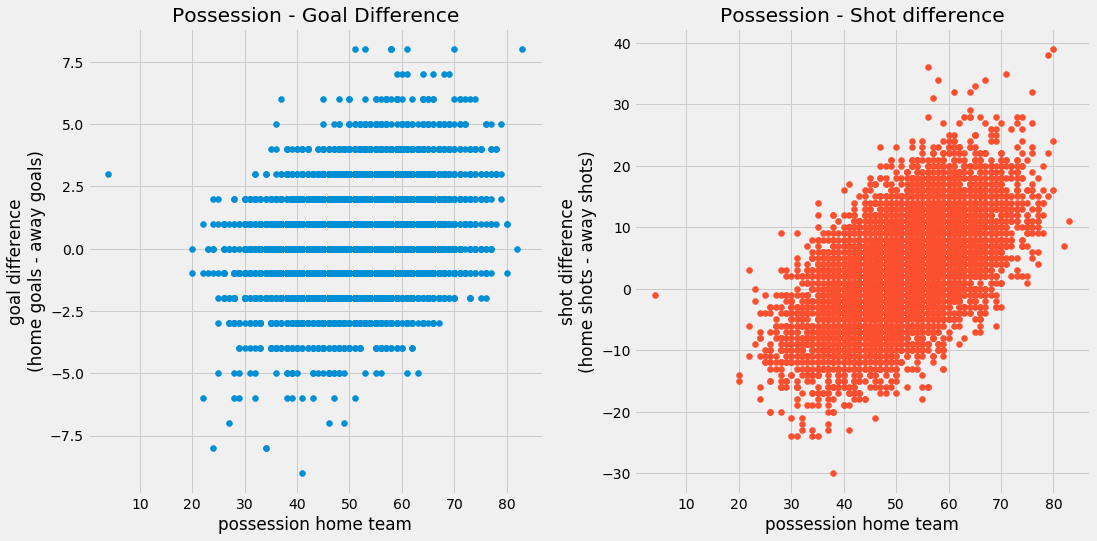

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].scatter(df_matches['homepos'], df_matches['goaldiff']) 
ax[0].set_xlabel('possession home team')
ax[0].set_ylabel('goal difference\n(home goals - away goals)')
ax[1].scatter(df_matches['homepos'], df_matches['shotdiff'], color='C1')
ax[1].set_xlabel('possession home team')
ax[1].set_ylabel('shot difference\n(home shots - away shots)')
ax[0].set_title('Possession - Goal Difference')
ax[1].set_title('Possession - Shot difference')

### Research Question 2  (Replace this header name!)

In [30]:
df_match_shots = df_match.merge(df_shots, on='match_id')
# possession, shoton, shotoff, goals not needed in df_match_shots:
df_match_shots.drop(['possession', 'shoton', 'shotoff', 'goal'], axis=1, inplace=True)
df_match_shots[(df_match_shots['type'] == 'goal') & (df_match_shots['subtype'].isin(['saved', 'missed', 'crossbar', 'post','saved_back_into_play', 'saved']))]
# there are some subtypes of type goal which actually aren't goals:
no_goals_list = ['saved', 'missed', 'crossbar', 'post','saved_back_into_play', 'saved']
#df_match_shots[(df_match_shots['type'] == 'goal')]['subtype'].value_counts()
#create new column goalQ - True if shot was a goal, False if not
df_match_shots['goalQ'] = (df_match_shots['type'] == 'goal') & (~df_match_shots['subtype'].isin(no_goals_list))
df_player_shots = df_match_shots.groupby(['player', 'goalQ'])['shotcnt'].sum().reset_index()
df_player_shots
df_player_plus = None
df_player_plus = df_player.merge(df_player_shots[df_player_shots['goalQ']==True], left_on='player_api_id', right_on='player')
df_player_plus = df_player_plus.merge(df_player_shots[df_player_shots['goalQ']==False], left_on='player_api_id', right_on='player')
df_player_plus.drop(['player_x', 'goalQ_x', 'player_y', 'goalQ_y'], axis=1, inplace=True)
df_player_plus.rename(columns={"shotcnt_x":"goals", "shotcnt_y":"shots_missed"}, inplace=True)
df_player_plus['conversion rate'] = df_player_plus['goals'] / (df_player_plus['goals'] + df_player_plus['shots_missed'])
df_player_plus.sort_values(by='conversion rate', ascending=False)
df_player_plus[df_player_plus['goals']>50].sort_values(by='conversion rate', ascending=False)



NameError: name 'df_match' is not defined

### Research Question 3

In [95]:
probs = (df_matches['home_team_goal'] + df_matches['away_team_goal']).value_counts().sort_index()/df_matches.shape[0]
mean_goals = (df_matches['home_team_goal'] + df_matches['away_team_goal']).mean()
mean_goals

2.7323190300725066

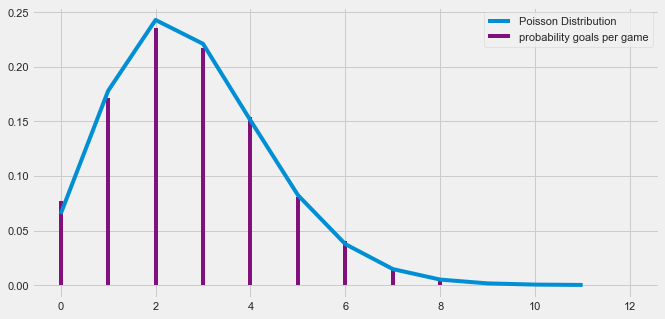

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
_ = ax.vlines(probs.index, probs.values, colors="C5", ymax=0, label="probability goals per game")
#_ = ax.hist(df_matches['away_team_goal'], bins='auto',  density=False)
ax.plot(range(0,12), poisson.pmf(range(0,12), 2.73), label="Poisson Distribution")
ax.legend()
#sns.set()
#ax = sns.(df_matches['home_team_goal'])

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!